# Test 6 (Simulated Annealing)

Field: 8mT along the x axis

In [210]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore some messages from pandas
import pandas as pd
from tqdm import tqdm
import random

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import get_colloids_from_ctrj, classifyVertices, count_vertices_single

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [211]:
# Some auxiliary functions

def getEnergy(col):
    B0 = 8*ureg.mT
    field = [1,0,0]*B0
    E = col.calculate_energy(B = field)
    return E.magnitude

def flipColloid(col, index):
    col2 = col.copy(deep = True)
    c = col2[index]
    c.colloid = -c.colloid
    c.direction = -c.direction
    col2[index] = c
    return col2

def flipColloids(col, amount):
    indices = np.random.randint(0,len(col)-1,amount)

    for index in indices:
        col = flipColloid(col,index)
    
    return col

def isaccepted(dE,T):

    if dE < 0:
        return True
    else:
        r = np.random.rand()
        if r < np.exp(-dE/T):
            return True
        else:
            return False

In [212]:
# Definition of colloids

sp = ice.spins()
# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = 0, 
            susceptibility_spread = 0.1,
            periodic = True)

        
col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

# Simulated Annealing

In [213]:
np.random.seed(1)

In [214]:
E0 = getEnergy(col)
col0 = col.copy(deep = True)
print(E0 / 1e6)

-0.17076179412745085


## Stuff to do

* Organize this code, delete tests
* Save all ctrj states
    * try to save in a pandas multiindex
    * how to make a pandas multiindex
    * how to add stuff to a pandas muliindex
* Save a data frame with the following information
    mc_step I II III IV V VI energy

In [156]:
state1 = col.to_ctrj()
state2 = flipColloids(col,10).to_ctrj()

In [186]:
mcsteps = [k for k in range(2)]
particles = state1.index.get_level_values("id").values

index = pd.MultiIndex.from_product([mcsteps,particles], names=["mcstep","id"])
trj = pd.DataFrame(columns=state1.columns.to_list(), index=index)
trj

x    y    z   dx   dy   dz   cx   cy   cz
mcstep id                                              
0      0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       2    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       3    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       4    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
...         ...  ...  ...  ...  ...  ...  ...  ...  ...
1      195  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       196  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       197  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       198  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
       199  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[400 rows x 9 columns]

In [193]:
trj.loc[0,:] = state1

In [199]:
v = ice.vertices()
v = v.colloids_to_vertices(col)
vertices = classifyVertices(v.vertices).dropna()
counts = count_vertices_single(vertices)
counts["fraction"].to_list()

100%|██████████| 200/200 [00:01<00:00, 147.69it/s]


[0.04938271604938271,
 0.2222222222222222,
 0.13580246913580246,
 0.2962962962962963,
 0.2716049382716049,
 0.024691358024691357]

In [217]:
def simulation(colloid, niter = 100):
    dataPath = "../data/test6/"

    # Initialize stuff
    vertexSeries = np.zeros((niter,6))
    energies = np.zeros(niter)

    # Save initial state
    energies[0] = E0
    colloid.to_ctrj().to_csv(dataPath + "trj0.csv")

    # No sé por qué debo de calcular esto primero xd
    Eold = getEnergy(colloid)

    T = 300

    for k in tqdm(range(1,niter)):
        
        newcolloid = colloid.copy(deep = True)
        newcolloid = flipColloids(newcolloid,3)

        Enew = getEnergy(newcolloid)
        dE = Enew - Eold

        # Accept or reject the change
        if isaccepted(dE,T):
            colloid = newcolloid.copy(deep = True)
            Eold = Enew
            energies[k] = Eold
        else:
            energies[k] = Eold
        
        # Store and save vertex counts
        v = ice.vertices()
        v = v.colloids_to_vertices(col)
        vertices = classifyVertices(v.vertices).dropna()
        counts = count_vertices_single(vertices)
        vertexSeries[k,:] = counts["fraction"].to_list()
        
        currentFile = f"trj{k}.csv"
        colloid.to_ctrj().to_csv(dataPath + currentFile)
        
        T = 0.9*T
    
    return colloid, energies, vertexSeries


In [218]:
col2, energies, vSeries = simulation(col,10)

100%|██████████| 9/9 [00:25<00:00,  2.87s/it]


In [232]:
dataSeries = np.hstack((vSeries,energies.reshape(-1,1)))
pdSeries = pd.DataFrame(data=dataSeries, columns=["I","II","III","IV","V","VI","energy"])
pdSeries

,I,II,III,IV,V,VI,energy
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-170761.794127
1,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-170924.278058
2,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-171252.291182
3,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-173402.038495
4,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-173626.448127
5,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-174016.595254
6,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-174342.514197
7,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-174342.514197
8,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-175217.020615
9,0.074074,0.222222,0.148148,0.222222,0.246914,0.08642,-175217.020615


In [219]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

Text(0.5, 0, 'MC Steps')

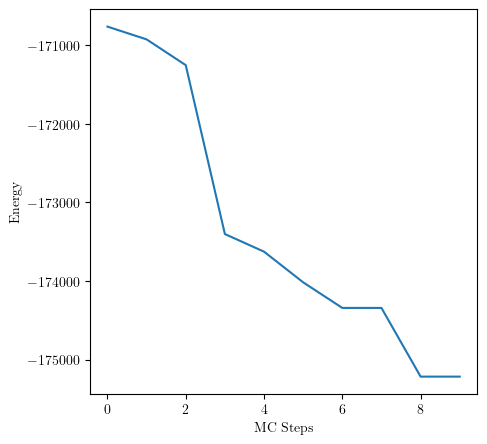

In [220]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(energies)
ax.set_ylabel("Energy")
ax.set_xlabel("MC Steps")

In [221]:
getEnergy(col2) / 1e6

-0.17521702061548164

In [68]:
dataPath = "../data/test6/"
pd.DataFrame(energies).to_csv(dataPath + "energies.csv")

In [222]:
energies[-1] / 1e6

-0.17521702061548164

100%|██████████| 200/200 [00:01<00:00, 127.42it/s]


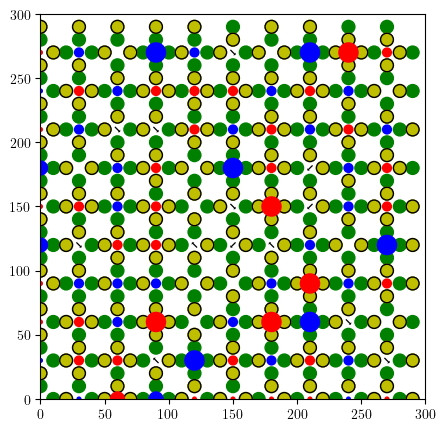

In [69]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col)
col.display(ax)
v.display()
fig.savefig("initial.png")

100%|██████████| 200/200 [00:01<00:00, 120.96it/s]


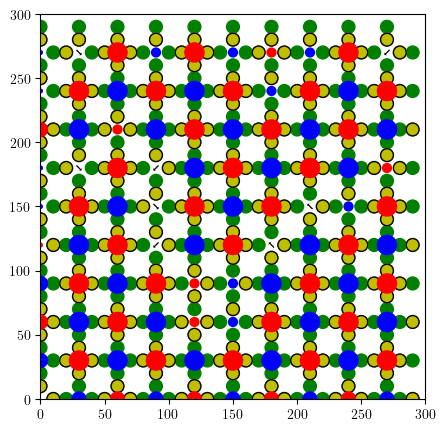

In [70]:
fig, ax = plt.subplots(figsize=(5,5))
v = ice.vertices()
v = v.colloids_to_vertices(col2)
col2.display(ax)
v.display()
fig.savefig("final.png")

In [401]:
sp = ice.spins()
# Initialize some parameters
trapSep = 10*ureg.um
particleRadius = 5*ureg.um
totalTime = 180*ureg.s

L = 30*ureg.um
N = 10

# Create simulation objects
sp.create_lattice("square",[N,N],lattice_constant=L, border="periodic")

particle = ice.particle(radius = particleRadius,
            susceptibility = 0.0576,
            diffusion = 0.125*ureg.um**2/ureg.s,
            temperature = 300*ureg.K,
            density = 1000*ureg.kg/ureg.m**3)

trap = ice.trap(trap_sep = trapSep,
            height = 4*ureg.pN*ureg.nm,
            stiffness = 1e-3*ureg.pN/ureg.nm)

col = ice.colloidal_ice(sp, particle, trap,
            height_spread = 0, 
            susceptibility_spread = 0.1,
            periodic = True)

        
col.randomize()
col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

Creo mi coloide inicial.

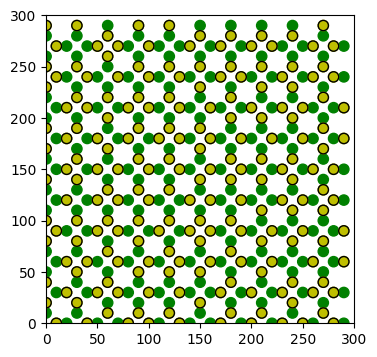

In [402]:
fig, ax = plt.subplots(figsize=(4,4))
col.display(ax)
fig.savefig("col0.png")

In [403]:
col2 = flipColloid(col,10)

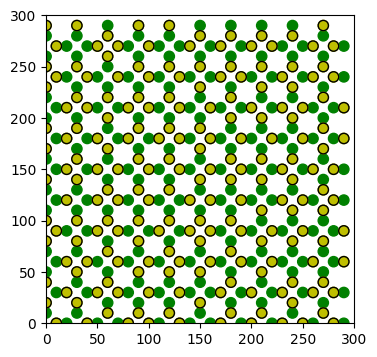

In [404]:
fig, ax = plt.subplots(figsize=(4,4))
col.display(ax)
fig.savefig("col1.png")

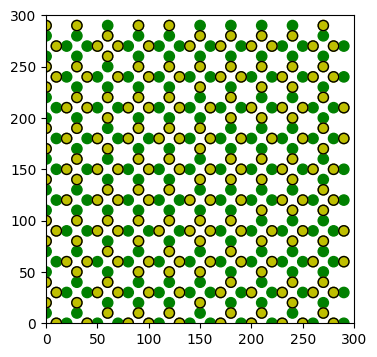

In [405]:
fig, ax = plt.subplots(figsize=(4,4))
col2.display(ax)
fig.savefig("col2.png")
